In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.8-py3-none-any.whl size=4847 sha256=5a3f0ea2d30aed8bd3d076f50f5bb992b65e9a67d641f72d9e0d15f70bd51b6f
  Stored in directory: /root/.cache/pip/wheels/63/ad/4c/8bf3f686c12a241375b9e8a1f51016ed192144808b278831dd
Successfully built mendelai-brat-parser
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

# **Relations Dataframe**

In [ ]:
# Import the datataset, created in a previous moment, (essay_relation_dataset.csv) 
# containing an entry for each relation of the Stab and Gurevych dataset.
# Each entry is composed as: 
# (type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, type if they are a premise or a claim, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport essay_relation_dataset.csv\n')
uploaded = files.upload()


Import essay_relation_dataset.csv



Saving essay_relation_dataset.csv to essay_relation_dataset.csv


In [ ]:
# The imported dataset is here directly used.
# MajorClaim have been removed from the argumentations in the imported dataset (they don't have labeled relations).

relation_ann_dataset=pd.read_csv('essay_relation_dataset.csv')

In [ ]:
relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length
0,supports,0,What we acquired from team work is not only ho...,Premise,5,0,"through cooperation, children can learn about ...",Claim,4,0
1,supports,0,"During the process of cooperation, children ca...",Premise,6,0,"through cooperation, children can learn about ...",Claim,4,0
2,supports,0,All of these skills help them to get on well w...,Premise,7,0,"through cooperation, children can learn about ...",Claim,4,0
3,supports,0,the significance of competition is that how to...,Premise,8,0,competition makes the society more effective,Claim,9,0
4,supports,0,when we consider about the question that how t...,Premise,10,0,"without the cooperation, there would be no vic...",Claim,14,0


In [ ]:
# Print some the dataset characteristics.
print("Informations about the dataset:\n")
print("Number element in the dataset: {}".format(len(relation_ann_dataset)))
print("Number effective relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']!='None'])))
print("Number support relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='supports'])))
print("Number attack relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='attacks'])))
print("Number premise supported by other premises: {}".format(len(relation_ann_dataset.loc[(relation_ann_dataset['supported_type']=='Premise')&(relation_ann_dataset['type']=='supports')])))

Informations about the dataset:

Number element in the dataset: 6243
Number effective relations: 3832
Number support relations: 3613
Number attack relations: 219
Number premise supported by other premises: 667


# **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

X_supporting_section_list=[]
X_supported_section_list=[]
X_type=[]

for relation in relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  type_supporting=relation.supporting_type
  type_supported=relation.supported_type

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  X_supporting_section_list.append(supporting)
  X_supported_section_list.append(supported)
  X_type.append([type_supporting,type_supported])

In [ ]:
X_supporting_section_list[:5]

['what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ']

In [ ]:
X_supported_section_list[:5]

['through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'competition makes the society more effective ',
 'without the cooperation , there would be no victory of competition ']

In [ ]:
X_type[:5]

[['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim']]

In [ ]:
X_type_temp=[]

for supporting, supported in X_type:

  if supporting=="Premise":
    supporting_type=1
  else:
    supporting_type=0

  if supported=="Premise":
    supported_type=1
  else:
    supported_type=0

  X_type_temp.append([supporting_type,supported_type])

X_type=X_type_temp

X_type_temp[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [ ]:
X_type=np.array(X_type)

In [ ]:
X_supported_word_list=[nltk.word_tokenize(section) for section in X_supported_section_list]
X_supporting_word_list=[nltk.word_tokenize(section) for section in X_supporting_section_list]

In [ ]:
Y_relation_type=relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'None']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_relation_type=Y_relation_type_temp

Y_relation_type[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 1, 2:8}

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in X_supporting_section_list]
MAX_LEN_SUPPORTING = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING))

text_len = [len(text) for text in X_supported_section_list]
MAX_LEN_SUPPORTED = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED))

Max lenght of the supporting argumentative sections: 350
Max lenght of the supporting argumentative sections: 282


In [ ]:
text_tokenizer_supporting = Tokenizer()
text_tokenizer_supporting.fit_on_texts(X_supporting_word_list)
X_supporting = text_tokenizer_supporting.texts_to_sequences(X_supporting_word_list)
X_supporting = pad_sequences(X_supporting, maxlen=MAX_LEN_SUPPORTING, padding="pre")

text_tokenizer_supported = Tokenizer()
text_tokenizer_supported.fit_on_texts(X_supported_word_list)
X_supported = text_tokenizer_supported.texts_to_sequences(X_supported_word_list)
X_supported = pad_sequences(X_supported, maxlen=MAX_LEN_SUPPORTED, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE_SUPPORTING = len(text_tokenizer_supporting.word_index) + 1
VOCABULARY_SIZE_SUPPORTED = len(text_tokenizer_supported.word_index) + 1

# Create an empty embedding matix
embedding_weights_supporting = np.zeros((VOCABULARY_SIZE_SUPPORTING, EMBEDDING_SIZE))
embedding_weights_supported = np.zeros((VOCABULARY_SIZE_SUPPORTED, EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id_supporting = text_tokenizer_supporting.word_index
word2id_supported = text_tokenizer_supported.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_supporting.items():
    try:
        embedding_weights_supporting[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported.items():
    try:
        embedding_weights_supported[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

to
,
and
of
a
's
'
;
’
``
''
part-time
:
his/her
face-to-face
15
co-worker
-
e-mail
high-tech
.
(
)
toefl
co-operative
penalty-kick
dish-washing
centre
well-being
learnt
30
long-time
travelling
multiple-choice
non-environmentally
he/she
co-tenant
10
2008
co-operation
“
40
well-rounded
well-trained
--
labelled
100
off-campus
comities
behaviour
environmentally-friendly
well-paid
devoiding
white-collar
team-working
artcrafts
e-learning
re-plays
self-independence
short-sighted
indira
89
state-of-the-art
–
cutting-edge
archuleta
high-quality
2003
test-takers
ibt
face-to
clear-cut
'halo
cutting-edged
group-studying
non-renewable
un-recyclable
co-workers
politian
indonesians
4:00
twenty-four
20th
sugesstions
foxconn
self-control
theoritical
top-level
to-do
trivials
high-ranking
burn-out
justing
british-ruled
behaviours
mncs
tradition-related
defence
non-globalized
‘
ivory-tower
one-third
gorvernment
1960
falseful
2010
enthuasism
garther
occupation-related
short-time
michaelangelo
picasso
rush

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

In [ ]:
X_argumentative_sections_doc=list(relation_ann_dataset['doc_id'])

sections_train_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

# **RNN**

In [ ]:
# Create and train recurrent models.

def train_supporting_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING, weights= [embedding_weights_supporting], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_supported_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED, weights= [embedding_weights_supported], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
def train_type_model(X_train:np.ndarray,Y_train:np.ndarray):

  # Create the model
  input = Input(shape=(2))

  model = Dense(2, activation='relu')(input)
  model = Dropout(0.2)(model)
  
  output = Dense(3, 'sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=150, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return model,input,final_model

In [ ]:
# Multimodal model.

def train_MultiModal(X_supporting_train:np.array, X_supported_train:np.array, X_type_train:np.array, Y_train:np.ndarray)->(Model,Model):

  # Create the others models.
  model_supporting,input_supporting=train_supporting_model(X_supporting_train)
  model_supported,input_supported=train_supported_model(X_supported_train)

  model_type,input_type, final_model_type=train_type_model(X_type_train,Y_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_supporting,model_supported,model_type])

  output = Dense(3, activation='softmax')(concatenation_layer)

  final_model=Model([input_supporting,input_supported,input_type],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_supporting_train,X_supported_train,X_type_train], Y_train, batch_size=64, class_weight=class_weights, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model, final_model_type

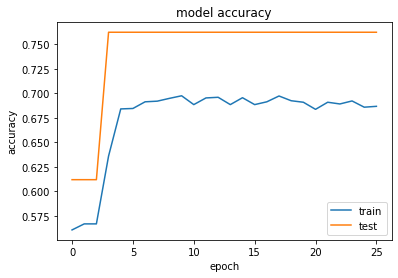

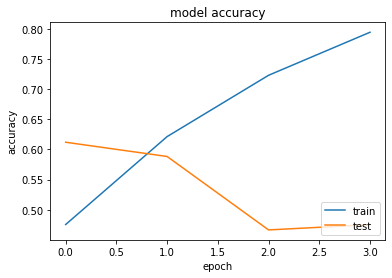

In [ ]:
target_names=['None','Support','Attack']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2).
categorical_Y = to_categorical(Y_relation_type)

X_supporting_train, X_supporting_test = X_supporting[sections_train_set], X_supporting[sections_test_set]
X_supported_train, X_supported_test = X_supported[sections_train_set], X_supported[sections_test_set]
X_type_train, X_type_test = X_type[sections_train_set], X_type[sections_test_set]
Y_train, Y_test = categorical_Y[sections_train_set], categorical_Y[sections_test_set]

# Train the model.
model,model_stat=train_MultiModal(X_supporting_train,X_supported_train,X_type_train,Y_train)

y_pred_temp=model.predict([X_supporting_test,X_supported_test,X_type_test])
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

        None       0.45      0.55      0.50       319
     Support       0.70      0.56      0.62       542
      Attack       0.05      0.11      0.07        28

    accuracy                           0.54       889
   macro avg       0.40      0.41      0.40       889
weighted avg       0.59      0.54      0.56       889



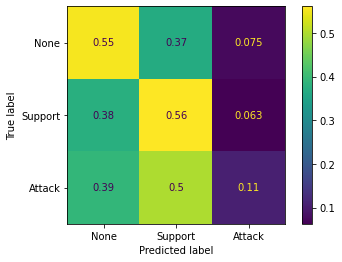

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stat model results**

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model_stat.predict(X_type_test).tolist()
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

        None       0.69      0.76      0.72       319
     Support       0.82      0.81      0.82       542
      Attack       0.00      0.00      0.00        28

    accuracy                           0.77       889
   macro avg       0.50      0.52      0.51       889
weighted avg       0.75      0.77      0.76       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


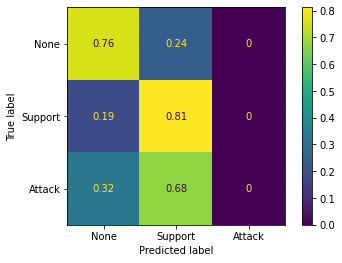

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()